In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import copy
from glob import glob
from shapely.geometry import box
import geopandas as gpd
from tqdm import tqdm 
import pickle
import gc
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
data_dir = '/mnt/CEPH_PROJECTS/sao/openEO_Platform'

In [3]:
big_pv_geoms = gpd.read_file(f"{data_dir}/germany_photovoltaic.shp")

In [4]:
# Filter the data to have farms bigger then 5 km2
big_pv_geoms_32632 = big_pv_geoms.to_crs(32632)
big_pv_geoms_32632_buffer_20 = copy.deepcopy(big_pv_geoms_32632)
big_pv_geoms_32632_buffer_20["geometry"] = [i.buffer(20) for i in big_pv_geoms_32632_buffer_20.geometry]
big_pv_geoms_buffer = big_pv_geoms_32632_buffer_20.to_crs(4326)


print(f"Number of selected PV Farms: {len(big_pv_geoms_buffer)}")

Number of selected PV Farms: 4458


In [5]:
bands = ['B01','B02','B03','B04',
         'B05','B06','B07','B08',
         'B8A', 'B11', 'B12']

### Extract the data

In [6]:
# Plot random PV farm
farm_id = 2

data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{farm_id}.nc",decode_coords="all")
geom = big_pv_geoms_32632.iloc[farm_id]  

# This step to fill the gaps (nan values) spatially
data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
data.rio.write_crs("epsg:32633", inplace=True) #32633

# Filter clouds pixels
cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32633")
data = data.where(~cloud_mask)

# Clip the farm polygon
clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

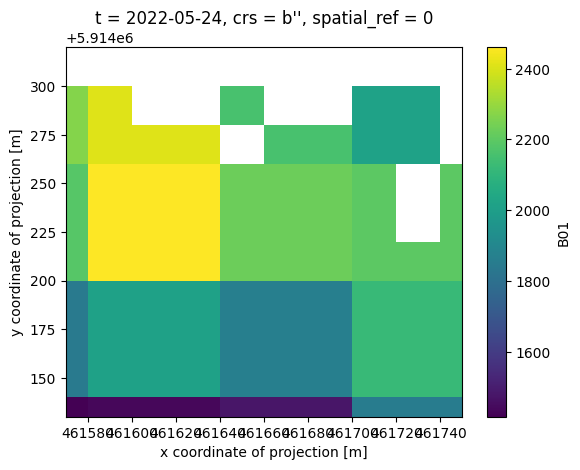

In [7]:
data['B01'][55].plot()

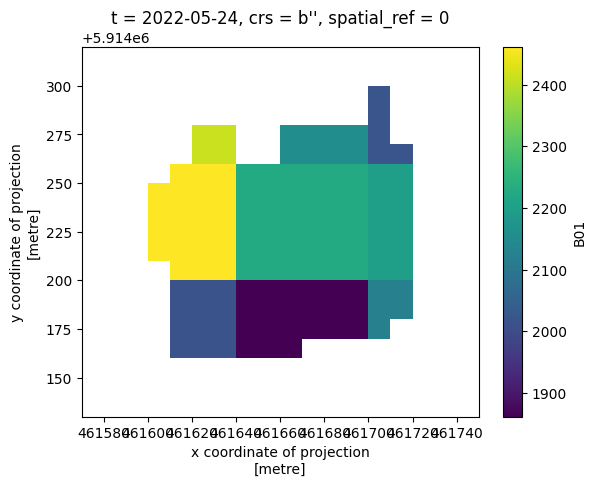

In [8]:
clipped['B01'][55].plot()

In [9]:
def temp_s2_data(stat_name, pv_farms, start_date='2022-01-01', end_date='2022-12-31', train=True, invert=False):
    
    all_pixels_ts = []
    for pv_farm in tqdm(pv_farms):
        farm_id = int(pv_farm.split('/')[-1].split('_')[-1].split('.')[0])
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{farm_id}.nc",decode_coords="all")
        geom = big_pv_geoms_32632.iloc[farm_id]


         # Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32633")
        data = data.where(~cloud_mask)  

        # This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633   

        # Filter the dataset based on time [Feb, Nov]
        filtered_ds = data.sel(t=slice(start_date, end_date))
            
        # Monthly stats 
        ds_monthly = filtered_ds.resample({"t": "M"}).apply(statistics_functions[stat_name])      
        
            
        # Linear interpolate for missing values 
        ds_monthly_interp = ds_monthly.interpolate_na(dim='t', method='linear')           
            
        # Crop the farm 
        clipped = ds_monthly_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=invert)    
        
        if train:
            df = clipped.to_dataframe().unstack(level='t')
        else:
            df = ds_monthly_interp.to_dataframe().unstack(level='t')
            
            
        arr_ts= []
        for b in bands:
            df_b = df[b]
            if train:
                df_b = df_b.dropna(how = 'all')
            if invert:
                # Randomly select 25% of the pixels 
                rows_to_filter = int(0.25 * len(df_b))
                df_b = df_b.sample(n=rows_to_filter, random_state=42)
                
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))
        
    
    samples = np.vstack(all_pixels_ts)
    
    return samples

In [66]:
# Define a list of statistics functions
statistics_functions = {
    "mean": lambda x: x.mean(dim="t",skipna=True),
    "median": lambda x: x.median(dim="t",skipna=True),
    "std": lambda x: x.std(dim="t",skipna=True),
}


# Define the list of statistics names
statistics_names = list(statistics_functions.keys())

In [ ]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"
pv_farms = glob(f"{data_dir}/s2/germany/*.nc")

# Initialize a dictionary to store the results
results = {}

# Loop through each statistic
for stat_name in statistics_names:
    ds_monthly = temp_s2_data(stat_name, pv_farms[500:]) 
    # Store the result in the dictionary
    results[stat_name] = ds_monthly 
    
pv_samples= np.concatenate(list(results.values()), axis=-1)
np.save(f'{data_dir}/s2/germany/extracted_temporal_data/pv_samples_monthly.npy', pv_samples)

In [ ]:
# Initialize a dictionary to store the results
results = {}

# Loop through each statistic
for stat_name in statistics_names:
    # Resample the dataset to monthly means using the current statistic function
    ds_monthly = temp_s2_data(stat_name, pv_farms[500:], invert=True) 
    # Store the result in the dictionary
    results[stat_name] = ds_monthly    
    

non_pv_samples= np.concatenate(list(results.values()), axis=-1)
np.save(f'{data_dir}/s2/germany/extracted_temporal_data/non_pv_samples_monthly.npy', non_pv_samples)

#### Combine both PV and Non-PV togehter 

In [26]:
pv_samples = np.load(f'{data_dir}/s2/germany/extracted_temporal_data/pv_samples_monthly.npy')
non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_temporal_data/non_pv_samples_monthly.npy')

In [27]:
y1 = np.ones(pv_samples.shape[0])
y0 = np.zeros(non_pv_samples.shape[0])

In [28]:
tr_data = np.vstack([pv_samples, non_pv_samples])
y = np.hstack([y1, y0])

In [ ]:
import gc
del pv_samples, non_pv_samples, y1, y0 ; gc.collect()

In [31]:
print(tr_data.shape)
print(y.shape)

(1546814, 11, 36)
(1546814,)


### 2D Modeling

In [33]:
tr_data = np.nan_to_num(tr_data, nan=-999999)

In [34]:
tr_data = tr_data.reshape(tr_data.shape[0], tr_data.shape[1]*tr_data.shape[2])
tr_data.shape

(1546814, 396)

In [35]:
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=2024) # for cross validation

# Creating loop for the stratified k fold
scores = []
i = 0
for train, val in skf.split(tr_data, y):
    print(f'########### Fold number {i+1} ')

    # spliting the data
    x_train, x_val = tr_data[train], tr_data[val]
    y_train, y_val = y[train], y[val]
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=2024)
    clf.fit(x_train, y_train)
    
    
    # Validation
    y_pred = clf.predict(x_val)
    score = accuracy_score(y_pred, y_val)
    scores.append(score)
    print(f'Accuracy Score: {score}')
    
    filename = f'../models/temporal_models/rf_monthly_temporal_{i+1}.sav'
    pickle.dump(clf, open(filename, 'wb'))

    i+=1
    break
print(f'Average F1 Score: {np.mean(scores)}')

########### Fold number 1 
Accuracy Score: 0.7172286278578887


NameError: name 'pickle' is not defined

### Test


#### Extract and prepare the data 

In [62]:
def temporal_metric(stat_name,  invert=False):
    start_date = '2022-02-01'
    end_date = '2022-11-30'
    
    all_pixels_ts = []
    #Keep 10% out to use them for testing 
    for i, geom in big_pv_geoms_32632[: 280].iterrows(): #280

        try:            
            data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
            ## Filter clouds pixels
            cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
            geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
            data = data.where(~cloud_mask)  

            ## This step to fill the gaps (nan values) spatially
            data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
            data.rio.write_crs("epsg:32633", inplace=True) #32633

            # Filter the dataset based on time [Feb, Nov]
            filtered_ds = data.sel(t=slice(start_date, end_date))

            # Weekly mean 
            ds_monthly = filtered_ds.resample({"t": "M"}).apply(statistics_functions[stat_name])

            # Linear interpolate for missing values 
            ds_monthly_interp = ds_monthly.interpolate_na(dim='t', method='linear')
            ds_monthly_interp.rio.write_crs("epsg:32633", inplace=True)
            
            clipped = ds_monthly_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=invert)
            
            #Extract the monthly mean 
            df = clipped.to_dataframe().unstack(level='t')
            arr_ts= []
            for b in bands:
                df_b = df[b]
                df_b = df_b.dropna(how = 'all')
                arr_ts.append(np.array(df_b))

            all_pixels_ts.append(np.stack(arr_ts, axis=1))   

        except:
            print(f"This polygon id: {i} is not exist.")
            
    samples = np.vstack(all_pixels_ts)
    return samples

In [68]:
# Initialize a dictionary to store the results
results = {}

# Loop through each statistic
for stat_name in statistics_names:
    # Resample the dataset to monthly means using the current statistic function
    ds_monthly = temp_s2_data(stat_name, pv_farms[:500]) #,train=False
    # Store the result in the dictionary
    results[stat_name] = ds_monthly 
    
te_samples= np.concatenate(list(results.values()), axis=-1)
np.save(f'{data_dir}/s2/germany/extracted_temporal_data/te_pv_samples_monthly.npy', te_samples)

In [70]:
# Initialize a dictionary to store the results
results = {}

# Loop through each statistic
for stat_name in statistics_names:
    # Resample the dataset to monthly means using the current statistic function
    ds_monthly = temp_s2_data(stat_name, pv_farms[:500], invert=True) 
    # Store the result in the dictionary
    results[stat_name] = ds_monthly 
    
te_samples= np.concatenate(list(results.values()), axis=-1)
np.save(f'{data_dir}/s2/germany/extracted_temporal_data/te_non_pv_samples_monthly1.npy', te_samples)

#### Test dataset - using 2d model

In [71]:
# load the model
clf = pickle.load(open(f'../models/temporal_models/rf_monthly_temporal_1.sav', 'rb'))

In [73]:
te_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_temporal_data/te_pv_samples_monthly.npy')
te_non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_temporal_data/te_non_pv_samples_monthly1.npy')

y1 = np.ones(te_pv_samples.shape[0])
y0 = np.zeros(te_non_pv_samples.shape[0])

In [74]:
te_samples = np.vstack([te_pv_samples, te_non_pv_samples])
y_test = np.hstack([y1, y0])

In [75]:
te_samples = te_samples.reshape(te_samples.shape[0], te_samples.shape[1]*te_samples.shape[2])
te_samples.shape

(257487, 396)

In [76]:
te_samples = np.nan_to_num(te_samples, nan=-999999)

In [77]:
te_pred = clf.predict(te_samples)

In [78]:
test_score = accuracy_score(te_pred, y_test)
print(f'Test Accuracy Score: {test_score}')

Test Accuracy Score: 0.6837199547938343


In [79]:
te_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_temporal_data/te_pv_samples_monthly.npy')
te_pv_samples = te_pv_samples.reshape(te_pv_samples.shape[0], te_pv_samples.shape[1]*te_pv_samples.shape[2])
te_pv_samples = np.nan_to_num(te_pv_samples, nan=-999999)

te_pred = clf.predict(te_pv_samples)

test_score = accuracy_score(te_pred, y1)
print(f'Test Accuracy Score for PV pixels: {test_score}')

Test Accuracy Score for PV pixels: 0.7832153792099583


## Plot

In [80]:
import leafmap.foliumap as leafmap
from shapely.geometry import mapping
import pyproj
import folium

In [81]:
leafmap.search_qms(keyword="google")

['qms.basemap.at',
 'qms.basemap.at Orthofoto',
 'qms.EOX::Maps - Sentinel-2 cloudless',
 'qms.Geoland Basemap',
 'qms.Geoland Basemap Gelände',
 'qms.Geoland Basemap Grau',
 'qms.Geoland Basemap High DPI',
 'qms.Geoland Basemap Oberfläche',
 'qms.Geoland Basemap Orthofoto',
 'qms.Geoland Basemap Overlay']

In [82]:
def json_s2_boundary(coords):
    bounds = (
        float(coords['x'].min()),  # minx
        float(coords['y'].min()),  # miny
        float(coords['x'].max()),  # maxx
        float(coords['y'].max())   # maxy
    )
    
    # Define the bounds
    minx, miny, maxx, maxy = bounds
    
    # Define the coordinates for the rectangle
    rectangle_coords = [
        [ minx, miny],
        [maxx,miny],
        [maxx, maxy],
        [minx, maxy],
        [minx, miny]  
        
    ]
    
    
    # Create a GeoJSON object for the rectangle
    rectangle_geojson = {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [rectangle_coords]
                },
                "properties": {}
            }
        ]
    }
    
    return rectangle_geojson

In [92]:
def extract_test_data(stat_name, pv_farm, start_date='2022-01-01', end_date='2022-12-31', train=True, invert=False):
    start_date = '2022-01-01'
    end_date = '2022-12-31'
    
    all_pixels_ts = []
    
    farm_id = int(pv_farm.split('/')[-1].split('_')[-1].split('.')[0])
    data = xr.open_dataset(f"{pv_farm}",decode_coords="all")
    coords = data.rio.reproject("EPSG:4326").coords
    s2_boundaries = json_s2_boundary(coords)
    
    geom = big_pv_geoms_32632.iloc[farm_id]
     # Filter clouds pixels
    cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
    geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32633")
    data = data.where(~cloud_mask)

    # This step to fill the gaps (nan values) spatially
    data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
    data.rio.write_crs("epsg:32633", inplace=True) #32633   

    # Filter the dataset based on time [Feb, Nov]
    filtered_ds = data.sel(t=slice(start_date, end_date))

     # Monthly stats 
    ds_monthly = filtered_ds.resample({"t": "M"}).apply(statistics_functions[stat_name])      


    # Linear interpolate for missing values 
    ds_monthly_interp = ds_monthly.interpolate_na(dim='t', method='linear')           
    ds_monthly_interp.rio.write_crs("epsg:32633", inplace=True)
    
    # Crop the farm 
    clipped = ds_monthly_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=invert)    

    if train:
        df = clipped.to_dataframe().unstack(level='t')
    else:
        df = ds_monthly_interp.to_dataframe().unstack(level='t')


    arr_ts= []
    for b in bands:
        df_b = df[b]
        if train:
            df_b = df_b.dropna(how = 'all')
        if invert:
            # Randomly select 25% of the pixels 
            rows_to_filter = int(0.25 * len(df_b))
            df_b = df_b.sample(n=rows_to_filter, random_state=42)

        arr_ts.append(np.array(df_b))

    all_pixels_ts.append(np.stack(arr_ts, axis=1))
    te_samples = np.vstack(all_pixels_ts)
    te_samples = np.nan_to_num(te_samples, nan=-999999)

        
    
    df_normal = df_b.reset_index()
    x_coords = df_normal[['x', 'y']].values[:,0]
    y_coords = df_normal[['x', 'y']].values[:,1]


    return te_samples, x_coords, y_coords, s2_boundaries

In [93]:
def farm_plot(farm_id, s2_boundaries):
    geom_wgs84 = big_pv_geoms_buffer.iloc[farm_id]
    centroid = geom_wgs84.geometry.centroid
    
    # Add the PV farm boundaries
    ## Convert the polygon boundary to GeoJSON format
    geojson_farm = mapping(geom_wgs84.geometry)    
    m = leafmap.Map(center=[centroid.y, centroid.x], zoom=15)
    m.add_xyz_service("qms.EOX::Maps - Sentinel-2 cloudless")
    folium.GeoJson(geojson_farm).add_to(m)
    
    # Add s2 boundaries
    folium.GeoJson(s2_boundaries).add_to(m)
    
    return m, geojson_farm

In [94]:
pv_farms = glob(f"{data_dir}/s2/germany/*.nc")

results = {}

# Loop through each statistic
for stat_name in statistics_names:
    ds_weekly, x_coords, y_coords, s2_boundaries = extract_test_data(stat_name, pv_farms[3686], train=False) 
    # Store the result in the dictionary 
    results[stat_name] = ds_weekly  
    
te_samples = np.concatenate(list(results.values()), axis=-1)
te_samples = te_samples.reshape(te_samples.shape[0], te_samples.shape[1]*te_samples.shape[2])

In [86]:
pv_farm = pv_farms[3686]
farm_id = int(pv_farm.split('/')[-1].split('_')[-1].split('.')[0])
m, geojson_farm = farm_plot(farm_id = farm_id, s2_boundaries = s2_boundaries)
m

In [95]:
# Predictions 
te_pred = clf.predict(te_samples)
te_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [96]:
def map_predictios(te_pred,x_coords, y_coords, geojson_farm, s2_boundaries):
    # Define the original CRS 
    original_crs = pyproj.CRS("EPSG:32632") 
    
    # Define the target CRS (WGS84)
    target_crs = pyproj.CRS("EPSG:4326")
    
    # Create a pyproj transformer to perform the coordinate transformation
    transformer = pyproj.Transformer.from_crs(original_crs, target_crs, always_xy=True)
    
    # Transform coordinates from the original CRS to WGS84
    lon, lat = transformer.transform(x_coords, y_coords)
    
    # Create a map centered at the mean of coordinates
    min_x, max_x = np.min(lon), np.max(lon)
    min_y, max_y = np.min(lat), np.max(lat)
    center = [(min_y + max_y) / 2, (min_x + max_x) / 2]
    m = leafmap.Map(location=center, zoom_start=15)
    m.add_xyz_service("qms.EOX::Maps - Sentinel-2 cloudless")
    
    # Add farm boundaries
    folium.GeoJson(geojson_farm).add_to(m)
    
    # Add s2 boundaries
    folium.GeoJson(s2_boundaries).add_to(m)
    
    # Iterate over each point in the array
    for x, y, value in zip(lon, lat, te_pred):
        # Add a marker with color based on the value
        if value == 1:
            folium.CircleMarker(
                location=[y, x],  
                radius=5,
                color='red',
                fill=True,
                fill_color='red'
            ).add_to(m)
            
    return m

In [97]:
map_predictios(te_pred,x_coords, y_coords, geojson_farm, s2_boundaries)